# Exxon Mobile Stock Price Prediction

1. Imports

In [1]:
#Imports
import math
import pandas as pd
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM
from matplotlib.pyplot import figure
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from statsmodels.graphics.tsaplots import plot_acf

2. Ingest Data

In [2]:
xom = yf.download('XOM', start='2019-01-01', end='2023-11-17')
xom

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,67.349998,69.870003,67.260002,69.690002,53.962502,16727200
2019-01-03,70.000000,70.250000,68.360001,68.620003,53.133984,13866100
2019-01-04,69.639999,71.269997,69.360001,71.150002,55.093029,16043600
2019-01-07,71.250000,72.099998,70.739998,71.519997,55.379517,10844200
2019-01-08,72.540001,72.589996,71.940002,72.040001,55.782181,11439000
...,...,...,...,...,...,...
2023-11-10,103.930000,104.410004,102.910004,103.750000,102.809875,17825500
2023-11-13,104.050003,105.139999,103.809998,104.839996,103.889992,15308400
2023-11-14,104.300003,104.820000,103.870003,104.290001,104.290001,18260500


<Axes: xlabel='Date'>

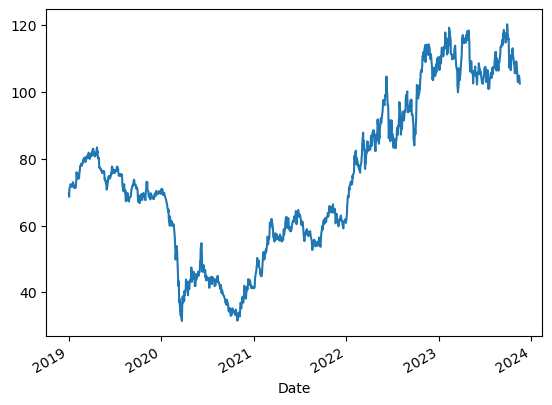

In [3]:
xom['Close'].plot()

3. Making an array for price difference

In [4]:
xom['Close First Difference'] = (xom['Close'] - xom['Close'].shift(1))

In [5]:
xom_pr = np.array(xom.reset_index()['Close First Difference'].dropna())

In [6]:
res=adfuller(xom['Close First Difference'].dropna())
print('ADF Statistic: %f' % res[0])
print('p-value: %f' % res[1])
for key, value in res[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -34.701913
p-value: 0.000000
	1%: -3.436
	5%: -2.864
	10%: -2.568


In [7]:

def searchARIMA(data, exog, max_p, max_q):
    aic = np.zeros((max_p, max_q))
    bic = np.zeros((max_p, max_q))
    
    for i in range(max_p):
        for j in range(max_q):
            try:
                if len(exog) == len(data):
                    model = ARIMA(data, order=(i, 0, j), exog=exog, trend='n')
                else:
                    model = ARIMA(data, order=(i, 0, j), trend='n')
                
                res_nee = model.fit()
                aic[i, j] = res_nee.aic
                bic[i, j] = res_nee.bic
                print('p:', i, ' q:', j, ' aic:', aic[i, j], ' bic:', bic[i, j])
                
            except Exception as e:
                print(f'Error for p={i}, q={j}: {e}')
                continue



4. Trying p and q vallues for ARIMA model

In [25]:
xom_n=len(xom_pr)
xom_exog = np.ones(xom_n)
searchARIMA(xom_pr, xom_exog, max_p=6, max_q=3)

p: 0  q: 0  aic: 4452.832078051973  bic: 4463.0583622693875
p: 0  q: 1  aic: 4454.737914981912  bic: 4470.077341308033
p: 0  q: 2  aic: 4455.736341211737  bic: 4476.188909646566
p: 1  q: 0  aic: 4454.743491016637  bic: 4470.082917342758
p: 1  q: 1  aic: 4456.56717157442  bic: 4477.019740009248
p: 1  q: 2  aic: 4457.022851795762  bic: 4482.588562339298
p: 2  q: 0  aic: 4455.635988897053  bic: 4476.088557331881


C:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\Aditya\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


p: 2  q: 1  aic: 4456.939883949868  bic: 4482.505594493404
p: 2  q: 2  aic: 4456.154949149463  bic: 4486.833801801706
p: 3  q: 0  aic: 4455.761066277738  bic: 4481.326776821274
p: 3  q: 1  aic: 4457.217249745388  bic: 4487.89610239763
p: 3  q: 2  aic: 4457.448041977179  bic: 4493.240036738129
p: 4  q: 0  aic: 4456.732527403665  bic: 4487.411380055907
p: 4  q: 1  aic: 4458.732693753409  bic: 4494.524688514359
p: 4  q: 2  aic: 4458.889915983093  bic: 4499.795052852749
p: 5  q: 0  aic: 4458.732295075475  bic: 4494.524289836425
p: 5  q: 1  aic: 4460.73213323533  bic: 4501.637270104987
p: 5  q: 2  aic: 4460.556651794488  bic: 4506.574930772852


In [9]:
from statsmodels.tsa.arima.model import ARIMA
order = (0, 0, 0) 
model = ARIMA(xom_pr, order=order)
result = model.fit()
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1228
Model:                          ARIMA   Log Likelihood               -2224.416
Date:                Fri, 15 Dec 2023   AIC                           4452.832
Time:                        18:57:54   BIC                           4463.058
Sample:                             0   HQIC                          4456.680
                               - 1228                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0267      0.042      0.629      0.529      -0.056       0.110
sigma2         2.1923      0.063     34.535      0.000       2.068       2.317
Ljung-Box (L1) (Q):                   0.09   Jarque-

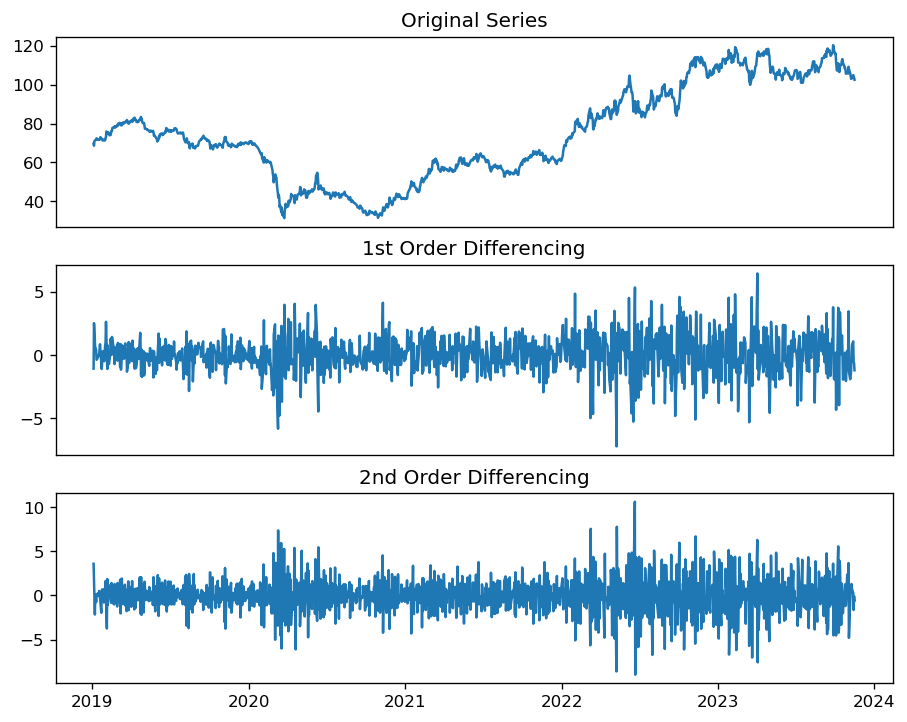

In [10]:
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})
 
# Original Series
fig, (ax1, ax2, ax3) = plt.subplots(3)
ax1.plot(xom.Close); ax1.set_title('Original Series'); ax1.axes.xaxis.set_visible(False)
# 1st Differencing
ax2.plot(xom.Close.diff()); ax2.set_title('1st Order Differencing'); ax2.axes.xaxis.set_visible(False)
# 2nd Differencing
ax3.plot(xom.Close.diff().diff()); ax3.set_title('2nd Order Differencing')
plt.show()

5. Train test split

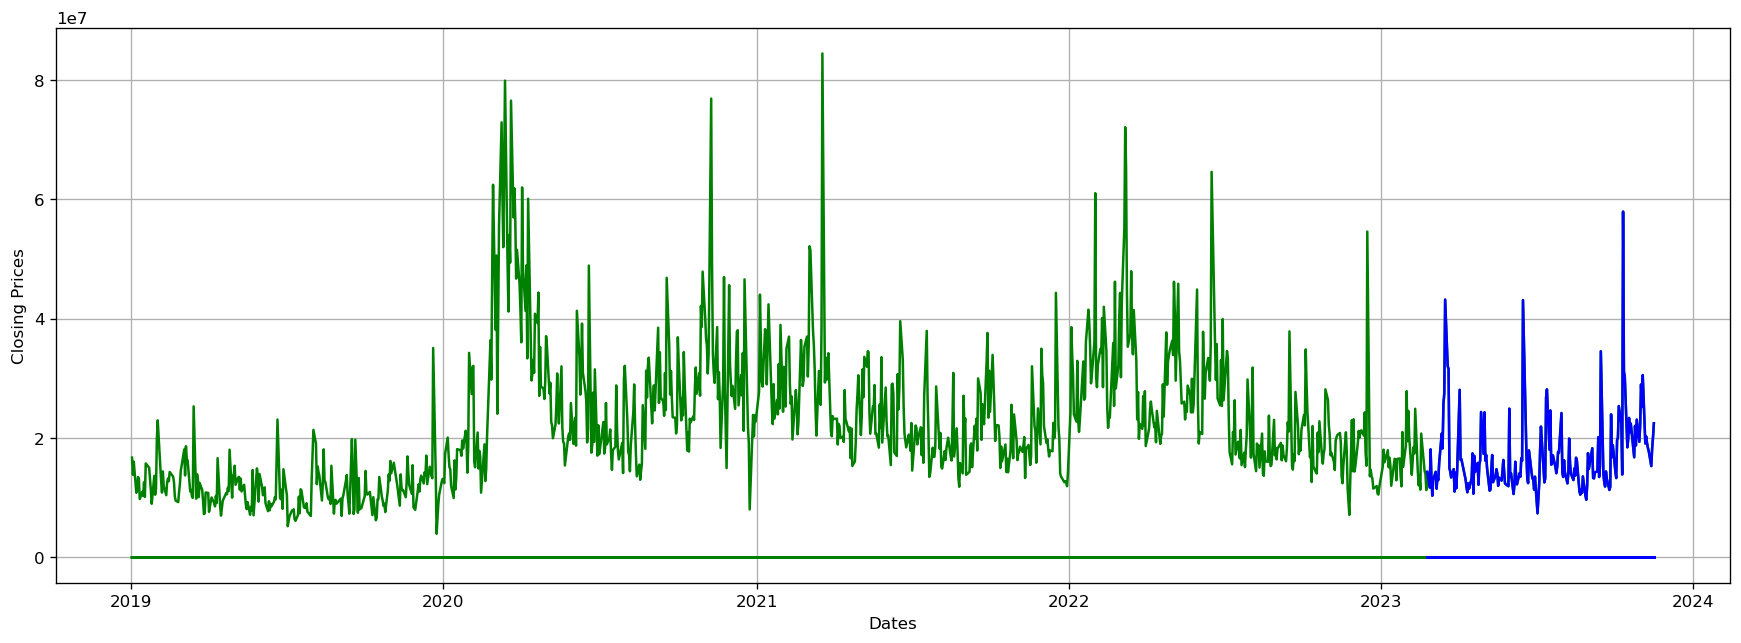

In [11]:
train_data, test_data = xom[0:int(len(xom)*0.85)], xom[int(len(xom)*0.85):]
training_data = train_data['Close'].values
testing_data = test_data['Close'].values
plt.figure(figsize=(18,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(xom, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')

6. Final ARIMA model

In [12]:
# Assuming training_data and testing_data are your time series data

history = [x for x in training_data]
model_predictions = []
N_test_observations = len(testing_data)

for time_point in range(N_test_observations):
    model = ARIMA(history, order=(0, 1, 0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    model_predictions.append(yhat)
    true_test_value = testing_data[time_point]
    history.append(true_test_value)

MSE_error = mean_squared_error(testing_data, model_predictions)
RMSE_error = math.sqrt(MSE_error)

print('Testing Mean Squared Error is {}'.format(MSE_error))
print('Testing Root Mean Squared Error is {}'.format(RMSE_error))


Testing Mean Squared Error is 3.0078675719676538
Testing Root Mean Squared Error is 1.7343204928638922


In [13]:
model_predictions = pd.DataFrame(model_predictions)

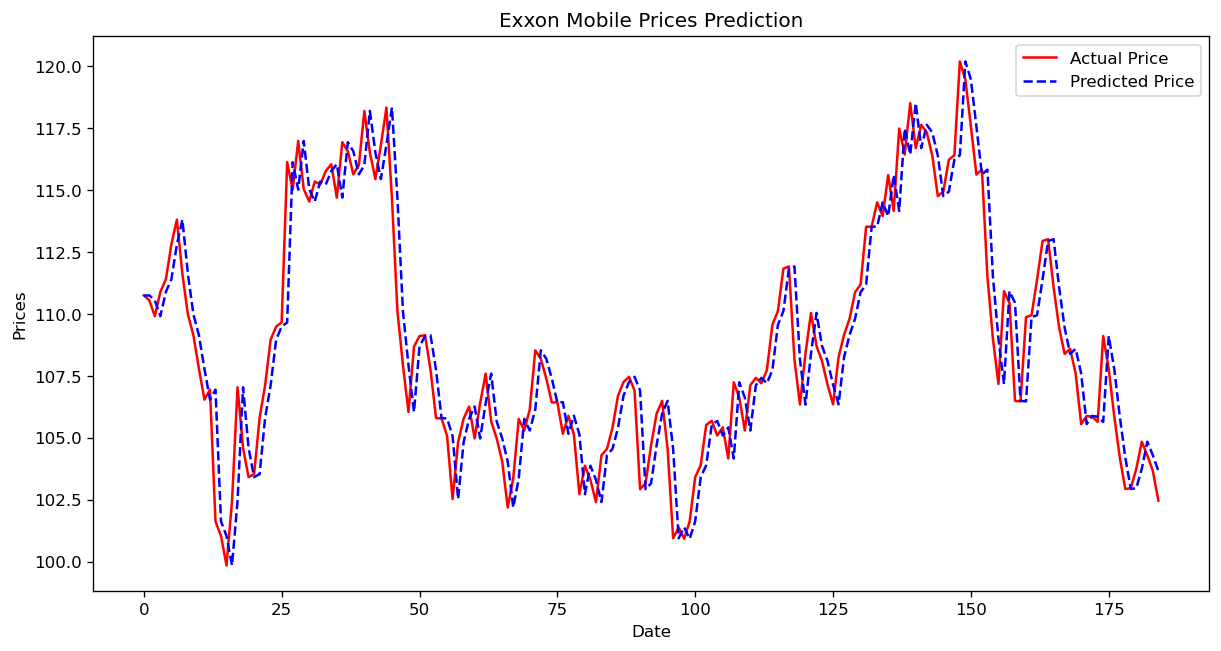

In [14]:
test_set_range = xom[int(len(xom)*0.85):].index
plt.figure(figsize=(12,6))
plt.plot(testing_data, color='red',label='Actual Price')
plt.plot(model_predictions, color='blue',linestyle='dashed',label='Predicted Price')
#plt.plot(test_data, color='red', label='Actual Price')
plt.title('Exxon Mobile Prices Prediction')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.legend()
plt.show()

7. LSTM Model

In [15]:
data = xom.filter(['Close'])
dataset = data.values
training_data_len = int(np.ceil( len(dataset) * .85))
training_data_len

1045

In [16]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.43087328],
       [0.41881694],
       [0.44732397],
       ...,
       [0.82073243],
       [0.81363387],
       [0.80011269]])

In [17]:
len(training_data)

1044

In [18]:
train_data = scaled_data[0:int(training_data_len), :]
test_data = scaled_data[training_data_len - 60: , :]

In [19]:
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])
    if i<= 61:
        print(x_train)
        print(y_train)
        
# Convert the x_train and y_train to numpy arrays 
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

[array([0.43087328, 0.41881694, 0.44732397, 0.45149293, 0.45735213,
       0.46163379, 0.45746483, 0.4537465 , 0.45273237, 0.45318309,
       0.45284507, 0.45836618, 0.46805633, 0.45566198, 0.44901413,
       0.45014087, 0.4537465 , 0.44833801, 0.45138032, 0.46016904,
       0.47132394, 0.50107041, 0.48867607, 0.49735208, 0.49363384,
       0.48709861, 0.47921132, 0.48056338, 0.4952113 , 0.50478875,
       0.50501406, 0.52123944, 0.52709864, 0.53047887, 0.52247888,
       0.52923943, 0.53014086, 0.53194372, 0.54107045, 0.53611268,
       0.54704227, 0.5505352 , 0.54918314, 0.53892958, 0.54884513,
       0.53588736, 0.54456338, 0.54704227, 0.55504226, 0.55200004,
       0.54873243, 0.5592113 , 0.55684512, 0.56191551, 0.56721129,
       0.55245076, 0.54614084, 0.55785916, 0.55087321, 0.55538027])]
[0.5560563877183677]
[array([0.43087328, 0.41881694, 0.44732397, 0.45149293, 0.45735213,
       0.46163379, 0.45746483, 0.4537465 , 0.45273237, 0.45318309,
       0.45284507, 0.45836618, 0.4680

In [20]:
# Create the testing data set
test_data = scaled_data[training_data_len - 60: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i, 0])   
# Convert the data to a numpy array
x_test = np.array(x_test)
# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [21]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(35))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
lstm_history = model.fit(x_train, y_train,validation_data= (x_test, y_test),batch_size=1, epochs=10)

Epoch 1/10
985/985 [==============================] - 42s 39ms/step - loss: 0.0026 - val_loss: 11686.4990
Epoch 2/10
985/985 [==============================] - 33s 33ms/step - loss: 0.0013 - val_loss: 11686.8496
Epoch 3/10
985/985 [==============================] - 25s 25ms/step - loss: 0.0010 - val_loss: 11678.5410
Epoch 4/10
985/985 [==============================] - 29s 29ms/step - loss: 8.2435e-04 - val_loss: 11676.3721
Epoch 5/10
985/985 [==============================] - 34s 34ms/step - loss: 7.7128e-04 - val_loss: 11675.7217
Epoch 6/10
985/985 [==============================] - 33s 34ms/step - loss: 7.2325e-04 - val_loss: 11680.7812
Epoch 7/10
985/985 [==============================] - 41s 41ms/step - loss: 6.2794e-04 - val_loss: 11688.3047
Epoch 8/10
985/985 [==============================] - 35s 36ms/step - loss: 6.2340e-04 - val_loss: 11680.2266
Epoch 9/10
985/985 [==============================] - 30s 31ms/step - loss: 5.6550e-04 - val_loss: 11685.3818
Epoch 10/10
985/985 [=

In [22]:
# Get the models predicted price values 
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

6/6 [==============================] - 1s 28ms/step


2.066772517933418

C:\Users\Aditya\AppData\Local\Temp\ipykernel_26268\2941357654.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


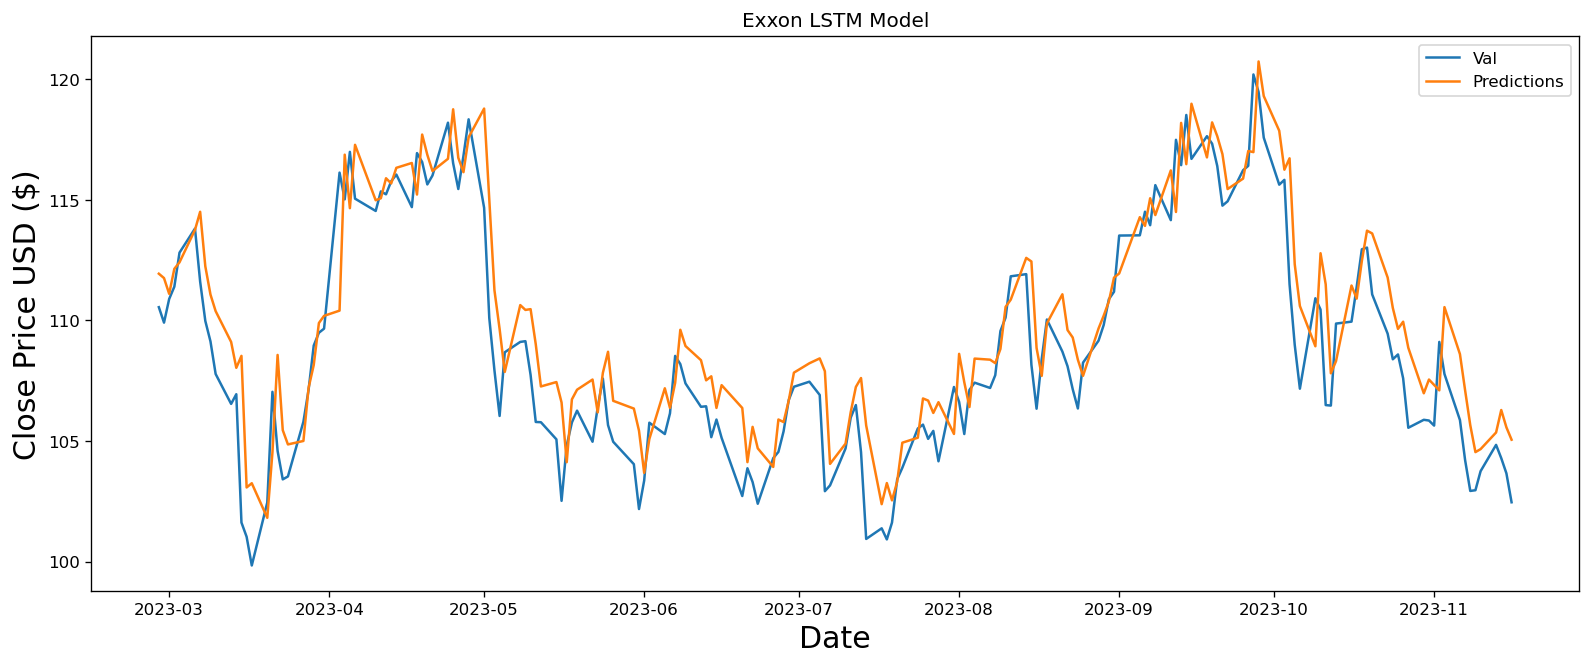

In [23]:
#Out of sample data
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Exxon LSTM Model')
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.plot(valid[['Close', 'Predictions']])
plt.legend([ 'Val', 'Predictions'], loc='upper right')
plt.show()

Text(0, 0.5, 'MSE')

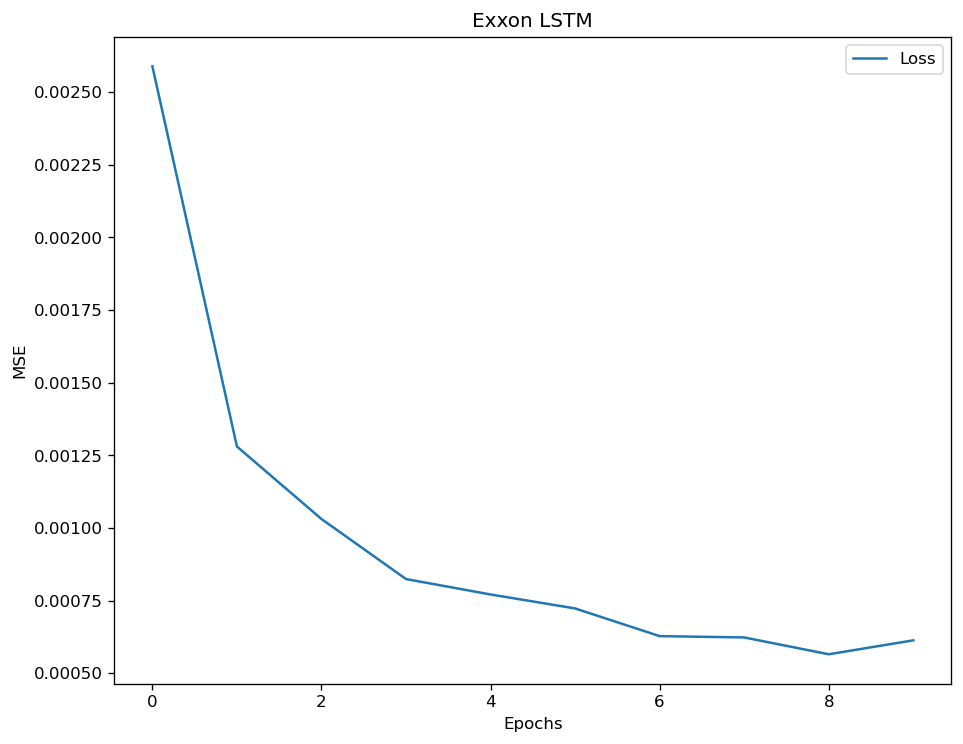

In [24]:
#Loss plot 
plt.plot(lstm_history.history['loss'], label='Loss')
plt.legend(loc='best')
plt.title('Exxon LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')